In [1]:
!cd yolov5 && pip install -r requirements.txt



In [2]:
!pip install xmltodict

In [3]:
!pip install split-folders

In [4]:
!pip install GPUtil

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

1. We will start preparing the data now


In [9]:
dataset = {
            "file":[],
            "classnames":[],
            "class_id":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [10]:
img_names=[] 
annotations=[]
for dirname, _, filenames in os.walk("Input/"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)
            
len(img_names)

756

In [11]:
len(annotations)

756

In [12]:
path_annotations="Input/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'name' in elem.tag:
            classname=elem.text
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['classnames'].append(classname)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)

In [13]:
classes = ['without_mask', 'with_mask', 'mask_weared_incorrect']

for i, v in enumerate(dataset['classnames']):
    dataset['class_id'].append(classes.index(dataset['classnames'][i]))
    
classes

['without_mask', 'with_mask', 'mask_weared_incorrect']

In [14]:
df=pd.DataFrame(dataset)
df

,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299.png,without_mask,0,301,400,62,194,160,320
1,maksssksksss528.png,without_mask,0,301,400,43,169,149,308
2,maksssksksss500.png,with_mask,1,301,400,113,230,216,368
3,maksssksksss266.png,with_mask,1,301,400,74,205,180,330
4,maksssksksss716.png,without_mask,0,301,400,101,174,209,299
...,...,...,...,...,...,...,...,...,...
3163,maksssksksss294.png,without_mask,0,400,241,271,73,278,82
3164,maksssksksss294.png,without_mask,0,400,241,236,91,243,99
3165,maksssksksss294.png,without_mask,0,400,241,236,76,243,83
3166,maksssksksss294.png,with_mask,1,400,241,264,76,268,82


In [12]:
print(f'''Sum of 'without_mask' labels: {sum(df.classnames == 'without_mask')}''')
print(f'''Sum of 'mask_weared_incorrect' labels: {sum(df.classnames == 'mask_weared_incorrect')}''')
print(f'''Sum of 'with_mask' labels: {sum(df.classnames == 'with_mask')}''')

Sum of 'without_mask' labels: 560
Sum of 'mask_weared_incorrect' labels: 0
Sum of 'with_mask' labels: 2608


As there are less number of enteries for mask weared incorrectly we will drop that class as it may hinder with the accuracy of our model

In [13]:
df = df[df.classnames != 'mask_weared_incorrect']
df.reset_index(drop=True, inplace=True)
classes = ['without_mask', 'with_mask']
df.head(10)

,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299.png,without_mask,0,301,400,62,194,160,320
1,maksssksksss528.png,without_mask,0,301,400,43,169,149,308
2,maksssksksss500.png,with_mask,1,301,400,113,230,216,368
3,maksssksksss266.png,with_mask,1,301,400,74,205,180,330
4,maksssksksss716.png,without_mask,0,301,400,101,174,209,299
5,maksssksksss845.png,with_mask,1,301,400,101,197,180,306
6,maksssksksss689.png,with_mask,1,560,315,293,153,361,212
7,maksssksksss851.png,with_mask,1,301,400,66,205,156,330
8,maksssksksss138.png,with_mask,1,400,267,51,144,128,239
9,maksssksksss138.png,with_mask,1,400,267,147,169,217,233


In [14]:
df

,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299.png,without_mask,0,301,400,62,194,160,320
1,maksssksksss528.png,without_mask,0,301,400,43,169,149,308
2,maksssksksss500.png,with_mask,1,301,400,113,230,216,368
3,maksssksksss266.png,with_mask,1,301,400,74,205,180,330
4,maksssksksss716.png,without_mask,0,301,400,101,174,209,299
...,...,...,...,...,...,...,...,...,...
3163,maksssksksss294.png,without_mask,0,400,241,271,73,278,82
3164,maksssksksss294.png,without_mask,0,400,241,236,91,243,99
3165,maksssksksss294.png,without_mask,0,400,241,236,76,243,83
3166,maksssksksss294.png,with_mask,1,400,241,264,76,268,82


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


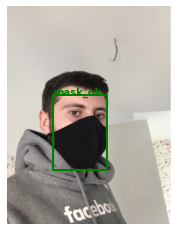

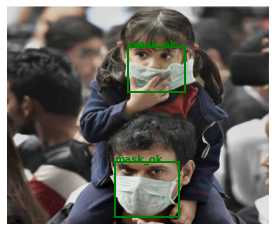

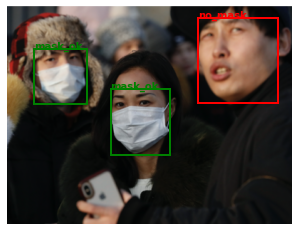

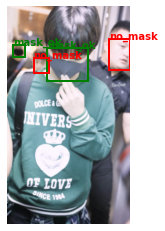

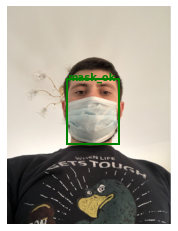

In [15]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                    
                    if df.class_id[i] == 0:
                        color = 'r'
                        annotation = 'no_mask'
                    elif df.class_id[i] == 1:
                        color = 'g'
                        annotation = 'mask_ok'
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor=color,facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate(annotation, (rx, ry), color=color, weight='bold', fontsize=10, ha='left', va='baseline')
                    
photos_path = "Input/images/*.png"
photos_list = glob.glob(photos_path)
len(photos_list)
print_random_images(photos_list)

Getting the data in the proper format so that we can use yolo

In [16]:
df.classnames.count

<bound method Series.count of 0       without_mask
1       without_mask
2          with_mask
3          with_mask
4       without_mask
            ...     
3163    without_mask
3164    without_mask
3165    without_mask
3166       with_mask
3167       with_mask
Name: classnames, Length: 3168, dtype: object>

In [17]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("Input/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = str(row.class_id) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("Input/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df


,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,maksssksksss299.png,without_mask,0,301,400,62,194,160,320,0.368771,0.642500,0.325581,0.315000
1,maksssksksss528.png,without_mask,0,301,400,43,169,149,308,0.318937,0.596250,0.352159,0.347500
2,maksssksksss500.png,with_mask,1,301,400,113,230,216,368,0.546512,0.747500,0.342193,0.345000
3,maksssksksss266.png,with_mask,1,301,400,74,205,180,330,0.421927,0.668750,0.352159,0.312500
4,maksssksksss716.png,without_mask,0,301,400,101,174,209,299,0.514950,0.591250,0.358804,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,maksssksksss294.png,without_mask,0,400,241,271,73,278,82,0.686250,0.321577,0.017500,0.037344
3164,maksssksksss294.png,without_mask,0,400,241,236,91,243,99,0.598750,0.394191,0.017500,0.033195
3165,maksssksksss294.png,without_mask,0,400,241,236,76,243,83,0.598750,0.329876,0.017500,0.029046
3166,maksssksksss294.png,with_mask,1,400,241,264,76,268,82,0.665000,0.327801,0.010000,0.024896


In [18]:
lst = os.listdir('Input/labels/') # your directory path
number_files = len(lst)
print(number_files)

756


In [19]:
input_folder = Path("Input")
output_folder = Path("yolov5/data/maskdetection")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 2268 files [00:00, 2526.21 files/s]

Moving files finished.


In [20]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 3 directiories and 0 files in 'Input' folder 
There are 0 directiories and 756 files in 'Input/images' folder 
There are 0 directiories and 756 files in 'Input/labels' folder 
There are 0 directiories and 756 files in 'Input/annotations' folder 

There are 2 directiories and 0 files in 'yolov5/data/maskdetection' folder 
There are 3 directiories and 1 files in 'yolov5/data/maskdetection/train' folder 
There are 0 directiories and 604 files in 'yolov5/data/maskdetection/train/images' folder 
There are 0 directiories and 604 files in 'yolov5/data/maskdetection/train/labels' folder 
There are 0 directiories and 604 files in 'yolov5/data/maskdetection/train/annotations' folder 
There are 3 directiories and 1 files in 'yolov5/data/maskdetection/val' folder 
There are 0 directiories and 152 files in 'yolov5/data/maskdetection/val/images' folder 
There are 0 directiories and 152 files in 'yolov5/data/maskdetection/val/labels' folder 
There are 0 directiories and 152 files in 'yolov5

In [21]:
import yaml

yaml_file = 'yolov5/data/masks.yaml'

yaml_data = dict(
    path = "data/maskdetection/",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)
    
device = '0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [75]:
start_time = timer()

!cd /content/drive/MyDrive/face_mask_detection/yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/masks.yaml" --weights yolov5s.pt --device {device} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/masks.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-205-geef9057 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=

In [7]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp16/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/shashankkatoch/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-10-25 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [15]:
cap = cv2.VideoCapture(0)

cap.isOpened()
while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    results = model(frame)
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
image 1/1: 667x1200 1 without_mask
Speed: 31.8ms pre-process, 410.8ms inference, 1.1ms NMS per image at shape (1, 3, 384, 640)


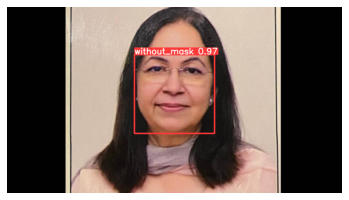

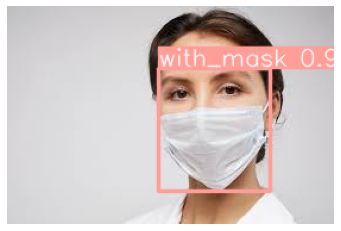

In [8]:
%pylab inline
test_photo_path = Path("withoutmask.jpeg")

results = model(test_photo_path)
print(results)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

test_photo_path = Path("withmask.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()